# Ideas for training
1. Instead of [0:5][5:10] as frames we can do [0:5][1:6][2:7]...
2. Shuffle TRAIN_ID, VALIDATION_ID, etc.

In [1]:
from ChalearnLAPSample import GestureSample
from tqdm import tqdm
from scipy.misc import imresize
import numpy as np
import tensorflow as tf
from scipy import stats
import util
import time

In [2]:
TRAIN_ID = range(1,11)         # Raw file format : Sample0001.zip - Sample0470.zip
VALIDATION_ID = range(471,481)  # Raw file format : Sample0471.zip - Sample0700.zip
TEST_ID = range(701,711)        # Raw file format : Sample0701.zip - Sample0941.zip
# TRAIN_LIST = range(1,471)         # Raw file format : Sample0001.zip - Sample0470.zip
# VALIDATION_LIST = range(471,701)  # Raw file format : Sample0471.zip - Sample0700.zip
# TEST_LIST = range(701,941)        # Raw file format : Sample0701.zip - Sample0941.zip

# Original image size is 480x640, crop to 320x320 then resize to 80x80
# TODO: change IMAGE_SiIZE, remove downsampling
CROP = (10, 330, 140, 460)
RESIZE_RATIO = 0.25
IMAGE_SIZE = (80, 80, 3)

In [3]:
RAW_DATA_PATH = './data/'
TFRecord_DATA_PATH = './tf-data/'

In [4]:
FRAMES_PER_CLIP = 8
MAX_FRAMES = 2000
CLIPS_PER_VIDEO = MAX_FRAMES / FRAMES_PER_CLIP

'''Self-defined gesture labels'''
NO_GESTURE = 21
EMPTY_PADDING = 22

(480, 640, 3)


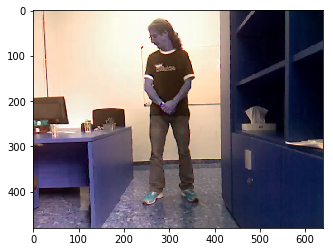

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

sample = GestureSample(RAW_DATA_PATH + 'Train/Sample0001.zip')
img = sample.getRGB(1)
print(img.shape)
plt.imshow(img)

# Create TFRecord

In [6]:
def get_data(path, data_type, write_path, sample_ids, label_path = None):
    for sample_id in tqdm(sample_ids):
        
        '''Get ChaLearn Data reader'''
        if label_path is not None: #data_type == 'Validation'
            sample = GestureSample('%s/%s/Sample%04d.zip'%(path, data_type, sample_id), 
                                   labelFileName=label_path + 'Sample%04d_prediction.csv'%sample_id)
        else: # data_type == 'Test', 'Train'
            sample = GestureSample('%s/%s/Sample%04d.zip'%(path, data_type, sample_id))
            
        '''Get label per frame'''
        gesture_list = sample.getGestures()
        num_of_frames = sample.getNumFrames()
        if (num_of_frames > MAX_FRAMES):
            raise Exception('Sample %d has %d Frames (> MAX_FRAMES:%d)' %(sample_id, num_of_frames, MAX_FRAMES))
            
        label = [EMPTY_PADDING] + [NO_GESTURE]* num_of_frames + [EMPTY_PADDING] * (MAX_FRAMES - num_of_frames)
        has_label = True if len(gesture_list) > 0 else False
        for gesture_id, start_frame, end_frame in gesture_list:
            label[start_frame:end_frame+1] = [gesture_id]*(end_frame + 1 - start_frame)
        
        '''Get sliced and cropped RGB data from the whole sample'''
        rgb = [np.zeros(IMAGE_SIZE)]
        for f in range(1, MAX_FRAMES+1):
            if (f > num_of_frames): # Add 0 paddings
                rgb_data = np.zeros(IMAGE_SIZE)
            else: 
                segmentation_mask = sample.getUser(f)
                if (segmentation_mask.sum() == 0):
                    label[f] = EMPTY_PADDING
                    print('Empty segmentation mask for Sample %d on frame %d' % (sample_id, f))
                rgb_data = sample.getRGB(f) * segmentation_mask
                rgb_data = rgb_data[CROP[0]:CROP[1], CROP[2]:CROP[3],:]
                rgb_data = imresize(rgb_data, RESIZE_RATIO, interp='bilinear')
            rgb += [rgb_data]
            
        '''Make it into clips'''
        rgbs = []
        labels = []
        for f in range(1, MAX_FRAMES+1, FRAMES_PER_CLIP):
            print(np.asarray(rgb[f:f+FRAMES_PER_CLIP]).shape)
            rgbs += [np.asarray(rgb[f:f+FRAMES_PER_CLIP])]
            labels += [int(stats.mode(label[f:f+FRAMES_PER_CLIP])[0])]
            
        print(np.asarray(rgbs).shape)
        print(np.asarray(labels).shape)
        '''Create TFRecord structure'''
        context = tf.train.Features(feature={'sample_id': util._int64_feature(sample_id)})
            
        featureLists = tf.train.FeatureLists(feature_list={
            'rgbs':util._bytes_feature_list(rgbs),
            'labels':util._int64_feature_list(labels)
        })
       
        sequence_example = tf.train.SequenceExample(context=context, feature_lists=featureLists)
        
        '''Write to .tfrecord file'''
    
        tf_write_option = tf.python_io.TFRecordOptions(compression_type=tf.python_io.TFRecordCompressionType.GZIP)
        filename = '%s/%s/Sample%04d.tfrecords' % (write_path, data_type, sample_id)
        tf_writer = tf.python_io.TFRecordWriter(filename, options=tf_write_option)
        tf_writer.write(sequence_example.SerializeToString())
        tf_writer.close()


In [7]:
get_data(RAW_DATA_PATH, 'Train', TFRecord_DATA_PATH, TRAIN_ID)
get_data(RAW_DATA_PATH, 'Validation', TFRecord_DATA_PATH, VALIDATION_ID, label_path = RAW_DATA_PATH + 'Validation_reference/')
#get_data(RAW_DATA_PATH, 'Test', TFRecord_DATA_PATH, TEST_ID)


  0%|          | 0/10 [00:00<?, ?it/s]

Empty segmentation mask for Sample 1 on frame 1
Empty segmentation mask for Sample 1 on frame 2
Empty segmentation mask for Sample 1 on frame 3
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(

 10%|█         | 1/10 [00:38<05:46, 38.54s/it]

Empty segmentation mask for Sample 2 on frame 1
Empty segmentation mask for Sample 2 on frame 2
Empty segmentation mask for Sample 2 on frame 3
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(

 20%|██        | 2/10 [01:09<04:49, 36.15s/it]


(250,)
Empty segmentation mask for Sample 3 on frame 1
Empty segmentation mask for Sample 3 on frame 2
Empty segmentation mask for Sample 3 on frame 3
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 

 30%|███       | 3/10 [01:36<03:54, 33.47s/it]

(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80

 40%|████      | 4/10 [02:17<03:35, 35.84s/it]

Empty segmentation mask for Sample 5 on frame 1
Empty segmentation mask for Sample 5 on frame 2
Empty segmentation mask for Sample 5 on frame 3
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(

 50%|█████     | 5/10 [02:58<03:07, 37.45s/it]

Empty segmentation mask for Sample 6 on frame 1
Empty segmentation mask for Sample 6 on frame 2
Empty segmentation mask for Sample 6 on frame 3
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(

 60%|██████    | 6/10 [03:29<02:21, 35.27s/it]

Empty segmentation mask for Sample 7 on frame 1
Empty segmentation mask for Sample 7 on frame 2
Empty segmentation mask for Sample 7 on frame 3
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(

 70%|███████   | 7/10 [03:53<01:36, 32.03s/it]

Empty segmentation mask for Sample 8 on frame 1
Empty segmentation mask for Sample 8 on frame 2
Empty segmentation mask for Sample 8 on frame 3
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(

 80%|████████  | 8/10 [04:25<01:03, 31.87s/it]

Empty segmentation mask for Sample 9 on frame 1
Empty segmentation mask for Sample 9 on frame 2
Empty segmentation mask for Sample 9 on frame 3
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(

 90%|█████████ | 9/10 [05:02<00:33, 33.46s/it]

Empty segmentation mask for Sample 10 on frame 1
Empty segmentation mask for Sample 10 on frame 2
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8

  0%|          | 0/10 [00:00<?, ?it/s]

(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80

 10%|█         | 1/10 [00:38<05:48, 38.77s/it]

Empty segmentation mask for Sample 472 on frame 1
Empty segmentation mask for Sample 472 on frame 2
Empty segmentation mask for Sample 472 on frame 3
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80

 20%|██        | 2/10 [01:14<05:04, 38.00s/it]

(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80

 30%|███       | 3/10 [02:03<04:49, 41.30s/it]

Empty segmentation mask for Sample 474 on frame 1
Empty segmentation mask for Sample 474 on frame 2
Empty segmentation mask for Sample 474 on frame 3
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80

 40%|████      | 4/10 [02:30<03:41, 36.98s/it]

Empty segmentation mask for Sample 475 on frame 1
Empty segmentation mask for Sample 475 on frame 2
Empty segmentation mask for Sample 475 on frame 3
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80

 50%|█████     | 5/10 [03:03<02:58, 35.62s/it]

Empty segmentation mask for Sample 476 on frame 1
Empty segmentation mask for Sample 476 on frame 2
Empty segmentation mask for Sample 476 on frame 3
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80

 60%|██████    | 6/10 [03:30<02:12, 33.06s/it]

Empty segmentation mask for Sample 477 on frame 1
Empty segmentation mask for Sample 477 on frame 2
Empty segmentation mask for Sample 477 on frame 3
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80

 70%|███████   | 7/10 [03:58<01:34, 31.53s/it]

Empty segmentation mask for Sample 478 on frame 1
Empty segmentation mask for Sample 478 on frame 2
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)


 80%|████████  | 8/10 [04:31<01:03, 31.99s/it]

(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80

 90%|█████████ | 9/10 [05:07<00:33, 33.07s/it]

(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80, 3)
(8, 80, 80

100%|██████████| 10/10 [05:40<00:00, 33.29s/it]


(250,)
